In [ ]:
!pip install transformers
!pip install nmslib
!pip install faiss-cpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 58.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for nmslib: filename=nmslib-2.1.1-cp310-cp310-linux_x86_64.whl size=13572646 sha256=174543104a9fbb3d9d842974219db63e5eb9b08b517aaaeb2f284f634cac9b9b
  Stored in directory: /root/.cache/pip/wheels/21/1a/5d/4cc754a5b1a88405cad184b76f823897a63a8d19afcd4b9314
Successfully built nmslib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

#### Пример: семантическая близость

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.manifold import TSNE

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
import csv
import numpy as np

sentences = []

with open('dataset_train.tsv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for row in reader:
        if len(row[0]) > 5: sentences.append(row[0])

sentences = list(set(sentences))  # Удаляем дубли

print(sentences[:10])
print(len(sentences))

sentences = sentences[:10000]

['столовая в корпусе старом где есть кафетерий корпус старый', 'где есть цена общежития', 'как пройти призывной пункт', 'получать вайфай университета!', 'расположен где расписание группы 214520', 'заказать справку', 'ммф находится!', 'отыскать фмш', 'стол военноучетный где есть', 'сайт библиотеки?']
11945


**Загружаем предобученную модель.**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModel.from_pretrained('xlm-roberta-base')

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
model.cuda()

XLMRobertaModel(
  (embeddings): XLMRobertaEmbeddings(
    (word_embeddings): Embedding(250002, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): XLMRobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x XLMRobertaLayer(
        (attention): XLMRobertaAttention(
          (self): XLMRobertaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): XLMRobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=Tru

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


**Дообучаем модель на наших данных.**

In [ ]:
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

with torch.no_grad():
    model_output = model(**encoded_input.to(device))

sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask']).cpu()

**Посмотрим как примерно распологаются вектора предложений.**

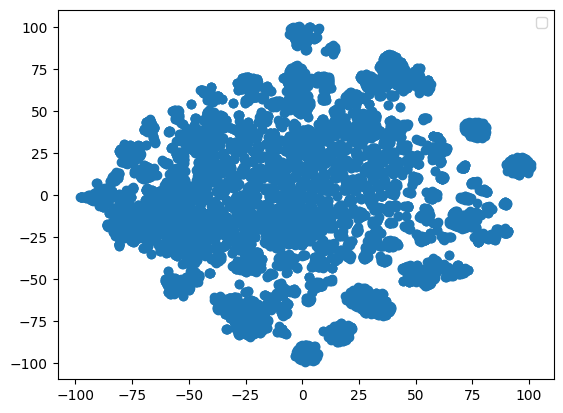

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, learning_rate='auto', init='random')
embedding = tsne.fit_transform(sentence_embeddings.numpy())

plt.scatter(embedding[:, 0], embedding[:, 1])
plt.legend()
plt.show()

Видим, что имеется много небольших кластеров.

**Разделим вектора предложений на классы (топ 20)**


In [ ]:
import nmslib

index = nmslib.init(method='hnsw', space='cosinesimil')
index.addDataPointBatch(sentence_embeddings, ids=list(range(len(sentence_embeddings))))
index.createIndex({'post': 2}, print_progress=True)

In [ ]:
indexes = []
removed = [False] * len(sentence_embeddings)

while True:
    idx = 0
    for _ in range(len(sentence_embeddings)):
        if not removed[idx]: break
        idx += 1
    if idx >= len(sentence_embeddings): break;

    idxs = []
    ids, distances = index.knnQuery(sentence_embeddings[idx], k=20)

    for i, d in zip(ids, distances):
        if (removed[i]): continue
        #if distance < 0.0022:
        idxs.append(i)
        removed[i] = True
    if len(idxs) == 0: break

    indexes.append(idxs)

print("Кол-во классов:", len(indexes))

Кол-во классов: 1499


**Посмотрим содержание класса 1.**

In [ ]:
np.array(sentences)[indexes[0]]

array(['столовая в корпусе старом где есть кафетерий корпус старый',
       'корпус старый бистро где есть кафе в корпусе старом',
       'поесть в корпусе старом корпус старый кафетерий расположен где',
       'кафе в корпусе старом корпус старый столовая распологается где',
       'столовка в корпусе старом столовая в корпусе старом распологается где',
       'где есть столовка в корпусе новом этаж четвертый',
       'корпус старый столовая кафе в корпусе старом находится',
       'этаж четвертый поесть в корпусе новом корпус главный 4 этаж кафетерий найти',
       'корпус старый точка питания расположен где кафетерий корпус старый',
       'где есть столовая в корпусе новом этаж первый',
       'столовая в корпусе старом где есть',
       'корпус новый этаж первый кафе 1 этаж поесть в корпусе новом где есть',
       'расположен где поесть в корпусе новом этаж четвертый',
       'где есть кафетерий корпус новый этаж четвертый',
       'где есть столовка в корпусе новом на этаже номер

**Посмотрим содержание класса 501.**





In [ ]:
np.array(sentences)[indexes[500]]

array(['институт цитологии и генетики со ран расположен где',
       'институт цитологии и генетики со ран идти',
       'институт цитологии и генетики со ран где есть',
       'институт цитологии и генетики со ран находится',
       'институт цитологии и генетики со ран пройти',
       'институт цитологии и генетики со ран найти',
       'находится институт цитологии и генетики со ран',
       'институт цитологии и генетики со ран попасть',
       'расположен где институт цитологии и генетики со ран',
       'институт цитологии и генетики со ран обнаружить',
       'идти институт цитологии и генетики со ран',
       'институт цитологии и генетики со ран ехать',
       'ехать институт цитологии и генетики со ран',
       'институт цитологии и генетики со ран раскопать',
       'попасть институт цитологии и генетики со ран',
       'институт цитологии и генетики со ран доехать',
       'пройти институт цитологии и генетики со ран',
       'доехать институт цитологии и генетики со ран'],

**Посмотрим содержание класса 701.**

In [ ]:
np.array(sentences)[indexes[700]]

array(['как найти Степанов В.Д.', 'как найти Березняков Д.В.',
       'как найти Власов В.Н.'], dtype='<U122')

**Предсказание произвольного предложения.**

In [ ]:
encoded_input = tokenizer(["нужна книжка"], padding=True, truncation=True, return_tensors='pt')

model.cpu()
model.eval()

with torch.no_grad():
    model_output = model(**encoded_input)

sentence_embed = mean_pooling(model_output, encoded_input['attention_mask'])

ids, distances = index.knnQuery(sentence_embed[0], k=10)

cls_id = 0
for idxs in indexes:
    if ids[0] in idxs: break
    cls_id += 1

print("Класс:", cls_id + 1)

np.array(sentences)[indexes[cls_id]]

Класс: 526


array(['найти библиотека', 'попасть библиотека', 'пройти библиотека',
       'библиотека найти', 'обнаружить библиотека',
       'как пройти библиотека', 'библиотека обнаружить',
       'ехать библиотека', 'оформить литература', 'потерял книги',
       'библиотека ехать', 'библиотека расположен где',
       'заказать литература', 'библиотека доехать', 'литература оформить'],
      dtype='<U122')

In [ ]:
encoded_input = tokenizer(["где сегодня Иванов А.А."], padding=True, truncation=True, return_tensors='pt')

model.cpu()
model.eval()

with torch.no_grad():
    model_output = model(**encoded_input)

sentence_embed = mean_pooling(model_output, encoded_input['attention_mask'])

ids, distances = index.knnQuery(sentence_embed[0], k=10)

cls_id = 0
for idxs in indexes:
    if ids[0] in idxs: break
    cls_id += 1

print("Класс:", cls_id + 1)

np.array(sentences)[indexes[cls_id]]

Класс: 233


array(['как найти Бабина К.А.', 'как найти Бакулина А.Ю.',
       'как найти Байкин А.Н.', 'как найти Кох К.А.',
       'как найти Голубева Л.А.', 'как найти Брагин О.А.',
       'как найти Опарин Г.А.', 'как найти Кремер И.А.',
       'как найти Чернусь С.А.', 'как найти Харламова Т.А.',
       'как найти Мамонтова М.А.', 'как найти Иванов С.А.'], dtype='<U122')

**Разделим вектора предложений на классы (ближайшие соседи)**

In [ ]:
import faiss

In [ ]:
num_classes = 1500   # Задаем кол-во классов

kmeans = faiss.Kmeans(sentence_embeddings.shape[1], num_classes, niter=30, verbose=True)
kmeans.train(sentence_embeddings)

3721.754150390625

**Индексы центроидов кластеров.**

In [ ]:
_, indexes = kmeans.index.search(sentence_embeddings, 1)
indexes

array([[  38],
       [1307],
       [ 806],
       ...,
       [ 204],
       [  19],
       [ 452]])

In [ ]:
np.array(sentences)[indexes[:20]]

array([['как найти Леоненко Н.Т.'],
       ['расписание преподавателя Аникина А.Б.'],
       ['стипендия социальная платить)'],
       ['ехать университет без пропуск'],
       ['найти сайт библиотеки)'],
       ['спортивный'],
       ['Привет, дружище'],
       ['институт математики разыскать'],
       ['расписание преподавателя Можейкина Л.Б.'],
       ['как медклиника'],
       ['расписание для Кравец И.А.'],
       ['без пропуск общежитие ехать'],
       ['хочу знать список приказов где тут находится'],
       ['zoom конференция оформить'],
       ['можно узнать где что находится пожалуйста'],
       ['план корпусов находится'],
       ['распологается где магазин продуктовый'],
       ['я не хочу учиться'],
       ['wifi в общежитии подключиться!'],
       ['как найти Лукинов В.Л.']], dtype='<U122')